In [1]:
%matplotlib inline
import json, pyes
from datetime import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd

# 連線至ElasticSearch伺服器
conn = pyes.es.ES("localhost:9200")

# 十組資安相關關鍵字、FilteredQuery
keywords = ["cve", "vulnerability", "exploit", "shellcode", "xss", "inject", "overflow", "csrf", "metasploit", "jailbreak"]
filter = pyes.filters.TermsFilter(field="text", values=keywords)
query = pyes.query.FilteredQuery(pyes.query.MatchAllQuery(), filter)

# 2.a - 共計有多少Twitter參與這類關鍵字議題討論？
search = pyes.query.Search(query, size=1)
uidAgg = pyes.aggs.TermsAgg('uidAgg', field='uid', size=0)
search.agg.add(uidAgg)
#print search.serialize()
result = conn.search(search, indices='twitter2' , doc_types='tweet')

#print result
#print result.count()
#print len(result)
#print json.dumps(result.aggs, indent=4)
print "[2.a] 共有 {} 位 Twitter 參與這些關鍵字討論".format(len(result.aggs["uidAgg"]["buckets"]))

[2.a] 共有 102 位 Twitter 參與這些關鍵字討論


In [2]:
# 2.b - 共計有多少Tweets?
search = pyes.query.Search(query, size=1)
result = conn.search(search, indices='twitter2' , doc_types='tweet')

#print result
#print result.count()
#print len(result)
count = 0
for i in result:
    count += 1
    #print json.dumps(i, indent = 4)
#print count
print "[2.b] 共有 {} 則 Tweets 提及這些關鍵字".format(len(result))

[2.b] 共有 6013 則 Tweets 提及這些關鍵字


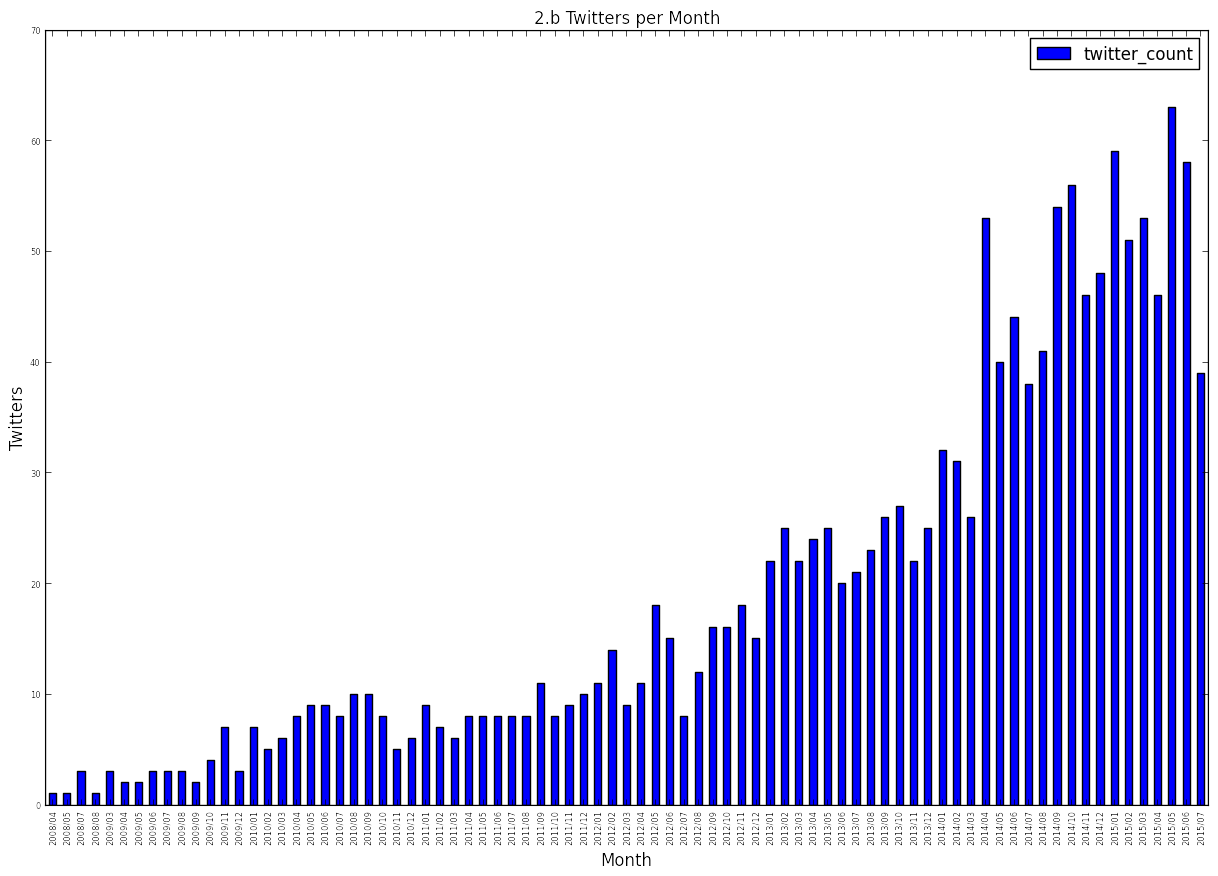

In [3]:
# 2.c - 每個月參與的Twitter數量長條圖
search = pyes.query.Search(query, size=1)
uidAgg = pyes.aggs.TermsAgg('uidAgg', field='uid', size=0)
monthAgg = pyes.aggs.DateHistogramAgg('monthAgg', field='created_at', interval="month", sub_aggs=[uidAgg])
search.agg.add(monthAgg)

#print search.serialize()

result = conn.search(search, indices='twitter2' , doc_types='tweet')

#print result
#print result.count()
#print len(result)
#print json.dumps(result.aggs, indent=4)

# 繪圖
twitter_list = []
for i in result.aggs["monthAgg"]["buckets"]:
    temp = {}
    month = dt.strptime(i["key_as_string"], '%a %b %d %H:%M:%S +0000 %Y')
    #print "{} 共有 {} 位 Twitter 討論".format(month.strftime('%Y/%m'), len(i["uidAgg"]["buckets"]))
    temp['month']= month.strftime('%Y/%m')
    temp['twitter_count'] = len(i['uidAgg']['buckets'])
    twitter_list.append(temp)
    
df = pd.DataFrame.from_records(twitter_list)
ax = df[['month','twitter_count']].plot(x='month',kind='bar', title ="2.b Twitters per Month", figsize=(15, 10),fontsize=6)
ax.set_xlabel("Month",fontsize=12)
ax.set_ylabel("Twitters",fontsize=12)

plt.show()

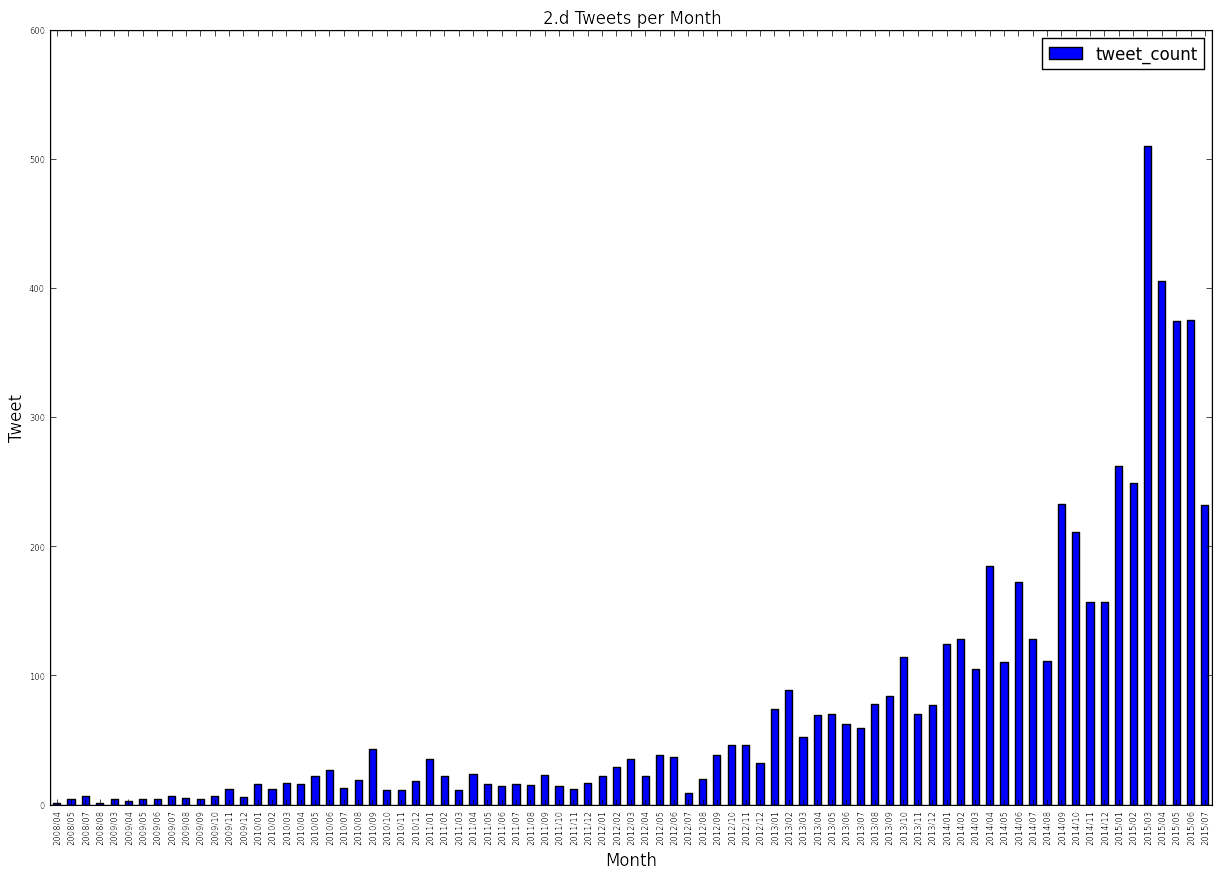

In [4]:
# 2.d - 每個月參與Tweets數量長條圖
search = pyes.query.Search(query, size=1)
#uidAgg = pyes.aggs.TermsAgg('uidAgg', field='uid', size=0)
monthAgg = pyes.aggs.DateHistogramAgg('monthAgg', field='created_at', interval="month")
search.agg.add(monthAgg)

result = conn.search(search, indices='twitter2' , doc_types='tweet')

# 繪圖
count = 0
#for i in result.aggs["monthAgg"]["buckets"]:
    #print i["doc_count"]
    #count += i['doc_count']
#print "---> {}".format(count)

tweet_list = []

for i in result.aggs["monthAgg"]["buckets"]:
    temp = {}
    month = dt.strptime(i["key_as_string"], '%a %b %d %H:%M:%S +0000 %Y')
    #print "{} 共有 {} 則 Tweets 討論".format(month.strftime('%Y/%m'), i["doc_count"])
    temp['month']= month.strftime('%Y/%m')
    temp['tweet_count'] = i["doc_count"]
    tweet_list.append(temp)
    
df = pd.DataFrame.from_records(tweet_list)
ax = df[['month','tweet_count']].plot(x='month',kind='bar', title ="2.d Tweets per Month", figsize=(15, 10),fontsize=6)
ax.set_xlabel("Month",fontsize=12)
ax.set_ylabel("Tweet",fontsize=12)

plt.show()

#print json.dumps(result.aggs, indent=4)

有 URL = 4636
無 URL = 1377


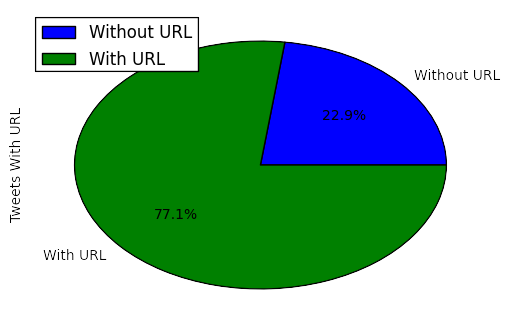

In [5]:
# 2.e - 其中有URL與無URL的Tweets的比例圓餅圖
search = pyes.query.Search(query)
result = conn.search(search, indices='twitter2' , doc_types='tweet')

countNoUrl = 0
countHasUrl = 0

for i in result:
    #print len(i["entities"]["urls"])
    if "http://" in i["text"] or "https://" in i["text"]:
        countHasUrl += 1
        #print i["text"]
        #print json.dumps(i["entities"], indent = 4)
        #print "-----------------------------------------"
    else:
        countNoUrl += 1
    #print json.dumps(i, indent=4)
print "有 URL = {}".format(countHasUrl)
print "無 URL = {}".format(countNoUrl)

url_list = [{"url":"without","Tweets With URL":countNoUrl},{"url":"with","Tweets With URL":countHasUrl}]
df = pd.DataFrame.from_records(url_list)
ax = df.plot.pie(y="Tweets With URL", labels = ["Without URL", "With URL"], autopct='%.1f%%')
plt.show()

In [6]:
# 2.f - 請依照每個月繪製各Twitter所提到CVE的箱型圖(每月最多發表帳號的次數、每月平均發表的次數、每月至少發表的次數、第一分位數、第三分位數)




In [20]:
# 2.g - 能否分析資安弱點分析指標帳號？如何分析？
search = pyes.query.Search(query)
result = conn.search(search, indices='twitter2' , doc_types='tweet')


s = []
count = 0


for i in result:
    count += 1
    #print json.dumps(i, indent = 4)
    if "retweeted_status" in i:
        s.append(i["retweet_count"])
        #print "{}\t{}".format(i["retweet_count"], i["retweeted_status"]["retweet_count"])
    #else:
        #print "{}\tNULL".format(i["retweet_count"])
        

#print "count = {}".format(count)
df = pd.DataFrame(s)
d = df.describe()
#print d
threshold = d[0]["50%"]

search = pyes.query.Search(query)
result = conn.search(search, indices='twitter2' , doc_types='tweet')

count = 0
keyuser = []
for i in result:
    if i["retweet_count"] >= threshold:
        count += 1
        if "retweeted_status" in i:
            # Retweeted tweet, find original twitter
            user = i["retweeted_status"]["user"]
        else:
            # Original Tweet
            user = i["user"]
        s = "{} (@{})".format(user["name"].encode("UTF-8"), user["screen_name"])
        #print s
        keyuser.append(s)

print "以下為retweet數量到達均標以上的指標帳號"
for k in set(keyuser):
    print k

以下為retweet數量到達均標以上的指標帳號
☩MalwareMustDie (@MalwareMustDie)
hasherezade (@hasherezade)
The Associated Press (@AP)
Nicolas Krassas (@Dinosn)
Jeremiah Grossman (@jeremiahg)
Mark J Cox (@iamamoose)
xntrik_ebooks (@xntrik)
netsparker (@netsparker)
Core Security (@CoreSecurity)
FireEye (@FireEye)
AV-TEST GmbH (@avtestorg)
✍ Daniel Miessler (@DanielMiessler)
Solar Designer (@solardiz)
SecWaza (@secwaza)
Nir Goldshlager (@Nirgoldshlager)
Alaeddine Mesbahi (@3asm_)
Louis Nadeau (@Cybpoulet)
Mustafa Al-Bassam (@musalbas)
Mario Vilas (@MarioVilas)
Abhibandu Kafle (@kabhi_kav)
QuickPWN (@QuickPWN)
StateOfTheInternet (@akamai_soti)
Katie Moussouris (@k8em0)
I Am Devloper (@iamdevloper)
beist (@beist)
stribikⓐ (@stribika)
Virus Bulletin (@virusbtn)
muts (@kalilinux)
Joshua Brindle (@Joshua_Brindle)
Jessy Irwin (@jessysaurusrex)
Paul Moore  (@Paul_Reviews)
Wade Alcorn (@WadeAlcorn)
Soroush Dalili (@irsdl)
TrustedSec  (@TrustedSec)
Scott Piper (@0xdabbad00)
Fedor Indutny (@indutny)
M.R.Vignesh Kumar (@